In [1]:
# We begin by importing the necessary libraries
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad
import time
from utilfuncs import Mesher, computeLocalElements, computeFilter
from mmaOptimize import optimize
import matplotlib.pyplot as plt

In [2]:
nelx, nely = 60, 30
elemSize = np.array([1., 1.])
mesh = {'nelx':nelx, 'nely':nely, 'elemSize':elemSize,\
        'ndof':2*(nelx+1)*(nely+1), 'numElems':nelx*nely}
mesh

{'nelx': 60,
 'nely': 30,
 'elemSize': array([1., 1.]),
 'ndof': 3782,
 'numElems': 1800}

In [3]:
material = {'Emax':1., 'Emin':1e-3, 'nu':0.3, 'penal':3.}

Filter

In [4]:
filterRadius = 1.5
H, Hs = computeFilter(mesh, filterRadius)
ft = {'type':1, 'H':H, 'Hs':Hs}
print("H:", H.shape, "\n", H)
print("Hs:", Hs.shape, "\n", Hs)

H: (1800, 1800) 
 [[1.5 0.5 0.  ... 0.  0.  0. ]
 [0.5 1.5 0.5 ... 0.  0.  0. ]
 [0.  0.5 1.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.5 0.5 0. ]
 [0.  0.  0.  ... 0.5 1.5 0.5]
 [0.  0.  0.  ... 0.  0.5 1.5]]
Hs: (1800,) 
 [2.58578644 3.17157288 3.17157288 ... 3.17157288 3.17157288 2.58578644]


In [5]:
example = 1
if(example == 1):
    # tip cantilever
    force = np.zeros((mesh['ndof'],1))
    dofs=np.arange(mesh['ndof'])
    fixed = dofs[0:2*(nely+1):1]
    free = jnp.setdiff1d(np.arange(mesh['ndof']),fixed)
    force[2*(nelx+1)*(nely+1)-2*nely+1, 0 ] = -1
    symXAxis = False
    symYAxis = False
elif(example == 2):
    ndof = 2*(nelx+1)*(nely+1)
    force = np.zeros((mesh['ndof'],1))
    dofs=np.arange(mesh['ndof'])
    fixed = dofs[0:2*(nely+1):1]
    free = jnp.setdiff1d(np.arange(mesh['ndof']),fixed)
    force[2*(nelx+1)*(nely+1)- (nely+1), 0 ] = -1
    symXAxis = True
    symYAxis = False
bc = {'force':force, 'fixed':fixed,'free':free,\
          'symXAxis':symXAxis, 'symYAxis':symYAxis}

In [6]:
globalVolumeConstraint = {'isOn':True, 'vf':0.5}

In [7]:
optimizationParams = {'maxIters':200,'minIters':100,'relTol':0.05}
projection = {'isOn':False, 'beta':4, 'c0':0.5}

In [8]:
class ComplianceMinimizer:
    def __init__(self, mesh, bc, material, \
                 globalvolCons, projection):
        self.mesh = mesh
        self.material = material
        self.bc = bc
        M = Mesher()
        self.edofMat, self.idx = M.getMeshStructure(mesh)
        self.K0 = M.getK0(self.material)
        self.globalVolumeConstraint = globalvolCons
        self.objectiveHandle = jit(value_and_grad(self. computeCompliance))
        
        self.consHandle = self.computeConstraints
        self.numConstraints = 1
        self.projection = projection
    #-----------------------#
    # Code snippet 2.1
    def computeCompliance(self, rho):
        #-----------------------#
        @jit
        # Code snippet 2.9
        def projectionFilter(rho):
            if(self.projection['isOn']):
                v1 = np.tanh(self.projection['c0']*self.projection['beta'])
                nm = v1 + jnp.tanh(self.projection['beta']*(rho-self.projection['c0']))
                dnm = v1 + jnp.tanh(self.projection['beta']*(1.-self.projection['c0']))
                return nm/dnm
            else:
                return rho
        #-----------------------#
        @jit
        # Code snippet 2.2
        def materialModel(rho):
            E = self.material['Emin'] + \
                (self.material['Emax']-self.material['Emin'])*\
                                (rho+0.01)**self.material['penal']
            return E
        #-----------------------#
##         @jit
          # Code snippet 2.8
#         def materialModel(rho): # RAMP
#             S = 8. # RAMP param
#             E = 0.001*self.material['Emax'] +\
#                     self.material['Emax']*(rho/ (1.+S*(1.-rho)) )
#             return E
#         Y = materialModel(rho)
        #-----------------------#
        @jit
        # Code snippet 2.3
        def assembleK(E):
            K_asm = jnp.zeros((self.mesh['ndof'], self.mesh['ndof']))
            K_elem = (self.K0.flatten()[np.newaxis]).T 
            # print(K_elem.shape)

            K_elem = (K_elem*E).T.flatten()
            K_asm = K_asm.at[(self.idx)].add(K_elem) #UPDATED
            return K_asm
        #-----------------------#
        @jit
        # Code snippet 2.4
        def solveKuf(K): 
            u_free = jax.scipy.linalg.solve\
                    (K[self.bc['free'],:][:,self.bc['free']], \
                    self.bc['force'][self.bc['free']], \
                    # sym_pos = True, check_finite=False)
                      check_finite=False)
            u = jnp.zeros((self.mesh['ndof']))
            u = u.at[self.bc['free']].set(u_free.reshape(-1)) #UPDATED
            return u
        #-----------------------#
        rho = projectionFilter(rho)
        E = materialModel(rho)
        K = assembleK(E)
        u = solveKuf(K)
        J = jnp.dot(self.bc['force'].T, u)[0]
        
        return J
    #-----------------------#
    def computeConstraints(self, rho, epoch): 
        @jit
        # Code snippet 2.6
        def computeGlobalVolumeConstraint(rho):
            g = jnp.mean(rho)/self.globalVolumeConstraint['vf'] - 1.
            return g
        # Code snippet 2.7
        c, gradc = value_and_grad(computeGlobalVolumeConstraint)\
                                    (rho);
        c, gradc = c.reshape((1,1)), gradc.reshape((1,-1))
        return c, gradc
    #-----------------------#
    def TO(self, optimizationParams, ft):
        optimize(self.mesh, optimizationParams, ft, \
             self.objectiveHandle, self.consHandle, self.numConstraints)

Iter 1; J 41.86; vf 0.80
Iter 2; J 80.96; vf 0.60
Iter 3; J 186.32; vf 0.46
Iter 4; J 246.20; vf 0.48
Iter 5; J 169.36; vf 0.49
Iter 6; J 134.28; vf 0.50
Iter 7; J 119.35; vf 0.50
Iter 8; J 111.77; vf 0.50
Iter 9; J 106.25; vf 0.50
Iter 10; J 100.92; vf 0.50


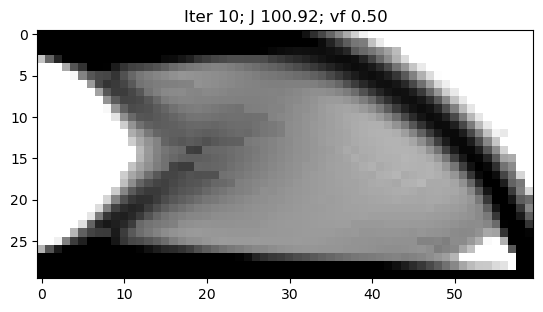

Iter 11; J 96.05; vf 0.50
Iter 12; J 91.75; vf 0.50
Iter 13; J 88.29; vf 0.50
Iter 14; J 85.16; vf 0.50
Iter 15; J 82.39; vf 0.50
Iter 16; J 80.14; vf 0.50
Iter 17; J 78.19; vf 0.50
Iter 18; J 76.39; vf 0.50
Iter 19; J 74.94; vf 0.50
Iter 20; J 73.64; vf 0.50


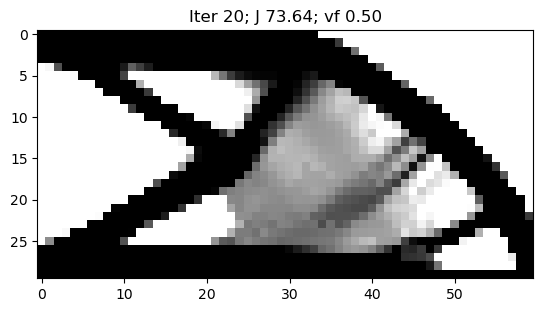

Iter 21; J 72.28; vf 0.50
Iter 22; J 71.10; vf 0.50
Iter 23; J 70.14; vf 0.50
Iter 24; J 69.27; vf 0.50
Iter 25; J 68.57; vf 0.50
Iter 26; J 67.96; vf 0.50
Iter 27; J 67.49; vf 0.50
Iter 28; J 67.05; vf 0.50
Iter 29; J 66.60; vf 0.50
Iter 30; J 66.19; vf 0.50


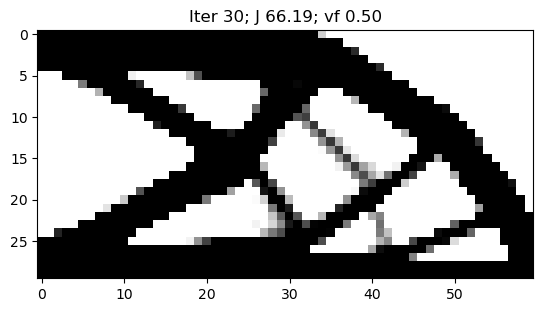

Iter 31; J 65.89; vf 0.50
Iter 32; J 65.69; vf 0.50
Iter 33; J 65.52; vf 0.50
Iter 34; J 65.40; vf 0.50
Iter 35; J 65.31; vf 0.50
Iter 36; J 65.27; vf 0.50
Iter 37; J 65.27; vf 0.50
Iter 38; J 65.23; vf 0.50
Iter 39; J 65.13; vf 0.50
Iter 40; J 65.00; vf 0.50


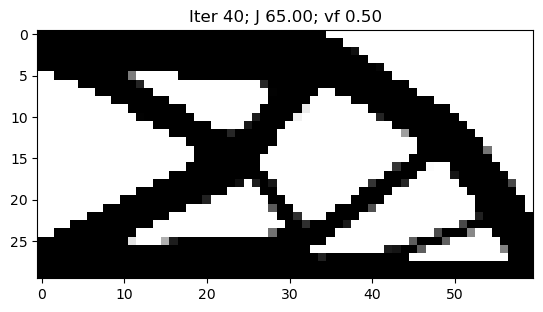

Iter 41; J 64.89; vf 0.50
Iter 42; J 64.88; vf 0.50
Iter 43; J 64.89; vf 0.50
Iter 44; J 64.88; vf 0.50
Iter 45; J 64.88; vf 0.50
Iter 46; J 64.88; vf 0.50
Iter 47; J 64.87; vf 0.50
Iter 48; J 64.86; vf 0.50
Iter 49; J 64.85; vf 0.50
Iter 50; J 64.84; vf 0.50


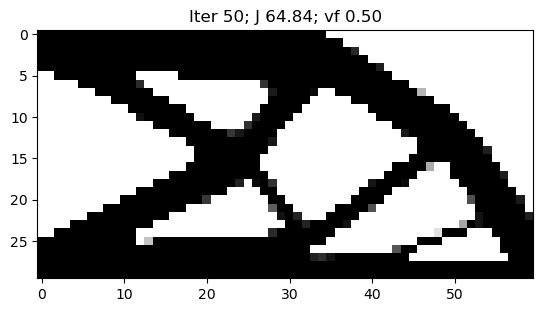

Iter 51; J 64.82; vf 0.50
Iter 52; J 64.79; vf 0.50
Iter 53; J 64.78; vf 0.50
Iter 54; J 64.77; vf 0.50
Iter 55; J 64.74; vf 0.50
Iter 56; J 64.73; vf 0.50
Iter 57; J 64.72; vf 0.50
Iter 58; J 64.72; vf 0.50
Iter 59; J 64.71; vf 0.50
Iter 60; J 64.71; vf 0.50


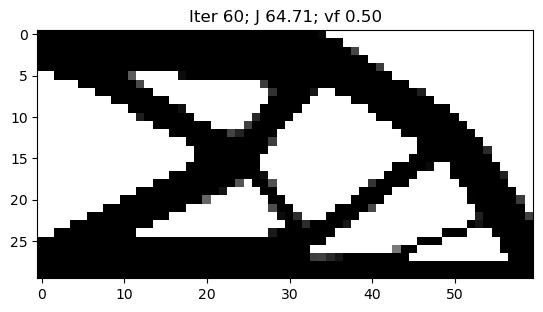

Iter 61; J 64.71; vf 0.50
Iter 62; J 64.70; vf 0.50
Iter 63; J 64.71; vf 0.50
Iter 64; J 64.71; vf 0.50
Iter 65; J 64.71; vf 0.50
Iter 66; J 64.71; vf 0.50
Iter 67; J 64.70; vf 0.50
Iter 68; J 64.69; vf 0.50
Iter 69; J 64.70; vf 0.50
Iter 70; J 64.69; vf 0.50


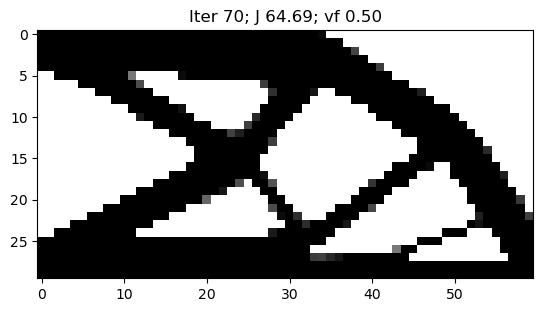

Iter 71; J 64.70; vf 0.50
Iter 72; J 64.70; vf 0.50
Iter 73; J 64.70; vf 0.50
Iter 74; J 64.71; vf 0.50
Iter 75; J 64.70; vf 0.50
Iter 76; J 64.69; vf 0.50
Iter 77; J 64.69; vf 0.50
Iter 78; J 64.67; vf 0.50
Iter 79; J 64.67; vf 0.50
Iter 80; J 64.67; vf 0.50


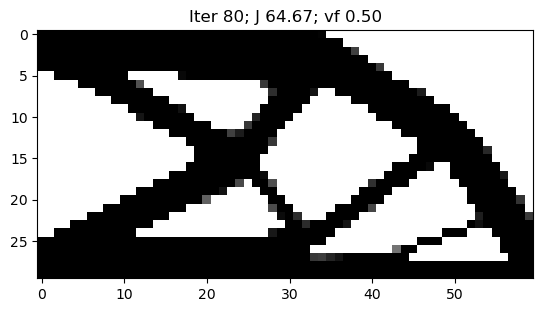

Iter 81; J 64.67; vf 0.50
Iter 82; J 64.67; vf 0.50
Iter 83; J 64.66; vf 0.50
Iter 84; J 64.66; vf 0.50
Iter 85; J 64.67; vf 0.50
Iter 86; J 64.66; vf 0.50
Iter 87; J 64.66; vf 0.50
Iter 88; J 64.67; vf 0.50
Iter 89; J 64.67; vf 0.50
Iter 90; J 64.67; vf 0.50


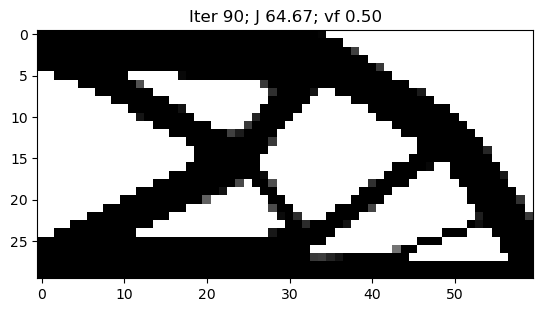

Iter 91; J 64.67; vf 0.50
Iter 92; J 64.66; vf 0.50
Iter 93; J 64.67; vf 0.50
Iter 94; J 64.66; vf 0.50
Iter 95; J 64.66; vf 0.50
Iter 96; J 64.67; vf 0.50
Iter 97; J 64.66; vf 0.50
Iter 98; J 64.67; vf 0.50
Iter 99; J 64.66; vf 0.50
Iter 100; J 64.67; vf 0.50


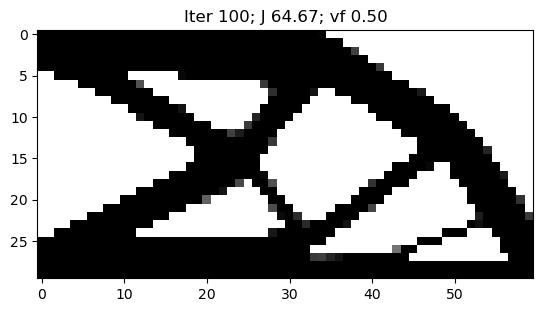

Iter 101; J 64.67; vf 0.50
Iter 102; J 64.67; vf 0.50
Iter 103; J 64.66; vf 0.50
Iter 104; J 64.67; vf 0.50
Iter 105; J 64.67; vf 0.50
Iter 106; J 64.67; vf 0.50
Iter 107; J 64.67; vf 0.50
Iter 108; J 64.67; vf 0.50
Iter 109; J 64.67; vf 0.50
Iter 110; J 64.67; vf 0.50


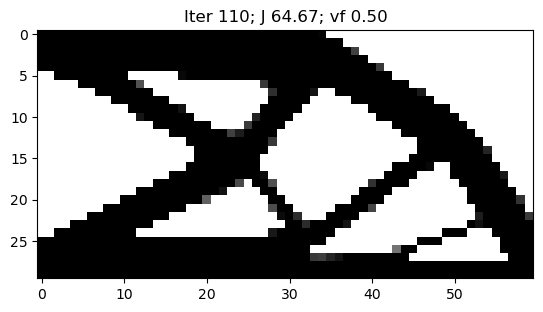

Iter 111; J 64.67; vf 0.50
Iter 112; J 64.67; vf 0.50
Iter 113; J 64.66; vf 0.50
Iter 114; J 64.67; vf 0.50
Iter 115; J 64.67; vf 0.50
Iter 116; J 64.66; vf 0.50
Iter 117; J 64.67; vf 0.50
Iter 118; J 64.67; vf 0.50
Iter 119; J 64.66; vf 0.50
Iter 120; J 64.67; vf 0.50


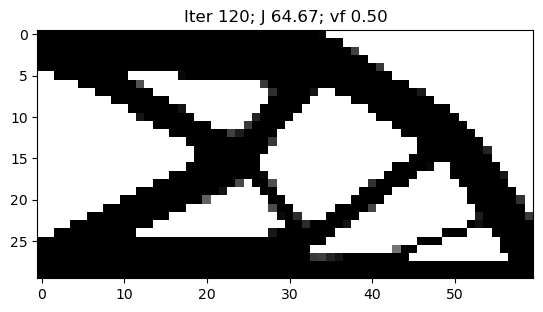

Iter 121; J 64.66; vf 0.50
Iter 122; J 64.67; vf 0.50
Iter 123; J 64.67; vf 0.50
Iter 124; J 64.67; vf 0.50
Iter 125; J 64.67; vf 0.50
Iter 126; J 64.67; vf 0.50
Iter 127; J 64.66; vf 0.50
Iter 128; J 64.66; vf 0.50
Iter 129; J 64.67; vf 0.50
Iter 130; J 64.67; vf 0.50


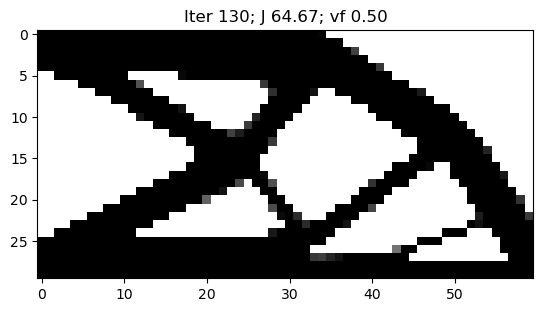

Iter 131; J 64.67; vf 0.50
Iter 132; J 64.67; vf 0.50
Iter 133; J 64.67; vf 0.50
Iter 134; J 64.66; vf 0.50
Iter 135; J 64.67; vf 0.50
Iter 136; J 64.67; vf 0.50
Iter 137; J 64.67; vf 0.50
Iter 138; J 64.67; vf 0.50


KeyboardInterrupt: 

In [ ]:
Opt = ComplianceMinimizer(mesh, bc, material, \
                globalVolumeConstraint, projection)
Opt.TO(optimizationParams, ft)